# **Análisis de la temporada 2020-21 de la NBA para Los Angeles Lakers (LAL)** 
---
<img src="logoNBA.png" width=700 height=900 /> 

## Importando librerias y cargando los datos a usar obtenidos en https://www.kaggle.com/schmadam97/nba-playbyplay-data-20182019?select=NBA_PBP_2020-21.csv

In [1]:
import numpy as np #Librería numérica
import pandas as pd #librería para el análisis y manipulación de datos
import matplotlib as mpl
from matplotlib import pyplot as plt #Librería gráfica
import seaborn as sns #Librería gráfica de complementación
from simple_colors import * #Imprimir con colores
from scipy.integrate import quad #Calcular integrales

In [2]:
import warnings
warnings.simplefilter(action='ignore')

# Configuramos el formato por defecto de la 
# librería de visualización Matplotlib.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 105
mpl.rcParams['figure.figsize'] = (9, 7)

## Definiendo una función que será de utilidad a la hora de graficar:

In [3]:
def barPerc(df,xVar,ax): #Agregar un porcentaje de matices a los gráficos de barras
    numX=len([x for x in df[xVar].unique() if x==x])

    bars = ax.patches

    for ind in range(numX):
    
        hueBars=bars[ind:][::numX]
        ## Obtiene la altura total para los porcentajes
        total = sum([x.get_height() for x in hueBars])

        # Imprime el porcentaje de las barras
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_height(),
                    f'{bar.get_height()/total:.0%}',
                    ha="center",va="bottom")

## Cargando y viendo las columnas del DataSet original:

In [4]:
df_original=pd.read_csv('NBA_PBP_2020-21.csv') # Archivo descargado previamente en el pc
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97673 entries, 0 to 97672
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   URL                 97673 non-null  object 
 1   GameType            97673 non-null  object 
 2   Location            97673 non-null  object 
 3   Date                97673 non-null  object 
 4   Time                97673 non-null  object 
 5   WinningTeam         97673 non-null  object 
 6   Quarter             97673 non-null  int64  
 7   SecLeft             97673 non-null  int64  
 8   AwayTeam            97673 non-null  object 
 9   AwayPlay            49379 non-null  object 
 10  AwayScore           97673 non-null  int64  
 11  HomeTeam            97673 non-null  object 
 12  HomePlay            48293 non-null  object 
 13  HomeScore           97673 non-null  int64  
 14  Shooter             37074 non-null  object 
 15  ShotType            37074 non-null  object 
 16  Shot

## Dado a que cada evento es único se procede a eliminar las filas que sean completamente iguales debido a posibles errores de digitación:

In [5]:
df_sin_duplicados= df_original.drop_duplicates() #remover filas completamente iguales

## Seleccionando los partidos regulares y las columnas necesarias para el análisis:

In [6]:
df_sin_duplicados=df_sin_duplicados[df_sin_duplicados['GameType']=='regular']

Columnas = ['Date','WinningTeam','Quarter','SecLeft','AwayTeam','AwayPlay','AwayScore',
            'HomeTeam','HomePlay','HomeScore','ShotType','ShotOutcome']

df=df_sin_duplicados[Columnas] 
df=df.reset_index()
df=df.drop(columns=['index'])
num_allseason=df['Date'].nunique()
print('Se cuenta con un total de',num_allseason,'partidos regulares durante lo transcurrido de la temporada')

Se cuenta con un total de 29 partidos regulares durante lo transcurrido de la temporada


## Viendo la información del dataset con las columnas de interés seleccionadas

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97564 entries, 0 to 97563
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         97564 non-null  object
 1   WinningTeam  97564 non-null  object
 2   Quarter      97564 non-null  int64 
 3   SecLeft      97564 non-null  int64 
 4   AwayTeam     97564 non-null  object
 5   AwayPlay     49326 non-null  object
 6   AwayScore    97564 non-null  int64 
 7   HomeTeam     97564 non-null  object
 8   HomePlay     48237 non-null  object
 9   HomeScore    97564 non-null  int64 
 10  ShotType     37070 non-null  object
 11  ShotOutcome  37070 non-null  object
dtypes: int64(4), object(8)
memory usage: 8.9+ MB


In [8]:
tg=df[df['Date']=='January 3 2021']

In [9]:
tg['AwayTeam'].unique()

array(['BOS', 'WAS', 'LAL', 'DEN', 'UTA', 'DAL', 'LAC', 'POR'],
      dtype=object)

### Se ve entonces que se pasaron de tener 97673 filas y 41 columnas a 97564 filas y 12 columnas.
## <span style="color:purple">Asignando 1 cuando gana LAL y 0 al caso contrario

In [10]:
df['W_P']=df['WinningTeam'] #creando una nueva columna 

In [11]:
df.loc[df.W_P!='LAL', 'W_P'] = 0 
df.loc[df.W_P=='LAL', 'W_P'] = 1

## Seleccionando los partidos donde participó LAL:

In [12]:
dfl_LAL=df[df['HomeTeam']=='LAL']
dfv_LAL=df[df['AwayTeam']=='LAL']
df_LAL=pd.concat([dfl_LAL,dfv_LAL])
df_LAL=df_LAL.reset_index()  #redefiniendo la cuenta del índice de cada fila

num_games=df_LAL['Date'].nunique()
P_acierto=df_LAL['ShotOutcome'].value_counts().min()/df_LAL['ShotOutcome'].value_counts().sum()

print('LAL ha jugado', black(num_games,['bold','underlined']),'partidos en el transcurso de la temporada, los cuales tuvieron un porcentaje'
      ' de acierto del',black(np.round(P_acierto*100,1),['bold','underlined']),'% \n (considerando cestas hechas y erradas por todos los equipos) ')

LAL ha jugado 15 partidos en el transcurso de la temporada, los cuales tuvieron un porcentaje de acierto del 46.6 % 
 (considerando cestas hechas y erradas por todos los equipos) 


In [13]:
df_LAL.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6927 entries, 0 to 6926
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        6927 non-null   int64 
 1   Date         6927 non-null   object
 2   WinningTeam  6927 non-null   object
 3   Quarter      6927 non-null   int64 
 4   SecLeft      6927 non-null   int64 
 5   AwayTeam     6927 non-null   object
 6   AwayPlay     3465 non-null   object
 7   AwayScore    6927 non-null   int64 
 8   HomeTeam     6927 non-null   object
 9   HomePlay     3462 non-null   object
 10  HomeScore    6927 non-null   int64 
 11  ShotType     2675 non-null   object
 12  ShotOutcome  2675 non-null   object
 13  W_P          6927 non-null   object
dtypes: int64(5), object(9)
memory usage: 757.8+ KB


## Hallando las probabilidades de ganar para LAL

In [14]:
P_All=df_LAL[df_LAL['AwayPlay']=='End of Game']['W_P'].mean()
P_l=dfl_LAL[dfl_LAL['AwayPlay']=='End of Game']['W_P'].mean()
P_v=dfv_LAL[dfv_LAL['AwayPlay']=='End of Game']['W_P'].mean()

print('En general LAL posee un porcentaje de victorias del', black(np.round(P_All*100,1),['bold','underlined']),'%')
print('De local LAL posee un porcentaje de victorias del',black(np.round(P_l*100,1),['bold','underlined']),'%')
print('De visitante LAL posee un porcentaje de victorias del',black(np.round(P_v*100,1),['bold','underlined']),'%')

En general LAL posee un porcentaje de victorias del 73.3 %
De local LAL posee un porcentaje de victorias del 50.0 %
De visitante LAL posee un porcentaje de victorias del 100.0 %


## Visualizando si el partido fue abierto o cerrado, su fecha y el equipo ganador:

In [15]:
df_dif=df_LAL[df_LAL['AwayPlay']=='End of Game']
df_dif=df_dif.reset_index()  
dif=[]
for i in range(num_games):
    dif.append(np.abs(df_dif.loc[i,'AwayScore']-df_dif.loc[i,'HomeScore']))
for i in range(num_games):
    if dif[i]<11:
        print('► El partido con',cyan(df_dif.loc[i,'HomeTeam'],['bold','reverse']), 'de' 
              ' local y',cyan(df_dif.loc[i,'AwayTeam'],['bold','reverse']),'de visitante,'
              'disputado en:',black(df_dif.loc[i,'Date'],['bold','underlined']),'fue un '
              ' partido', green('cerrado','bold'),'y ganó',magenta(df_dif.loc[i,'WinningTeam'],
                                                                  ['bold','reverse']) ,'\n')
    else: 
        print('► El partido con',cyan(df_dif.loc[i,'HomeTeam'],['bold','reverse']), 'de' 
              ' local y',cyan(df_dif.loc[i,'AwayTeam'],['bold','reverse']),'de visitante,'
              'disputado en:',black(df_dif.loc[i,'Date'],['bold','underlined']),'fue un'
              ' partido',   red('abierto','bold'),'y ganó',magenta(df_dif.loc[i,'WinningTeam'],
                                                                  ['bold','reverse']) ,'\n')

► El partido con LAL de local y LAC de visitante,disputado en: December 22 2020 fue un  partido cerrado y ganó LAC 

► El partido con LAL de local y DAL de visitante,disputado en: December 25 2020 fue un partido abierto y ganó LAL 

► El partido con LAL de local y MIN de visitante,disputado en: December 27 2020 fue un partido abierto y ganó LAL 

► El partido con LAL de local y POR de visitante,disputado en: December 28 2020 fue un  partido cerrado y ganó POR 

► El partido con LAL de local y SAS de visitante,disputado en: January 7 2021 fue un  partido cerrado y ganó SAS 

► El partido con LAL de local y CHI de visitante,disputado en: January 8 2021 fue un  partido cerrado y ganó LAL 

► El partido con LAL de local y GSW de visitante,disputado en: January 18 2021 fue un  partido cerrado y ganó GSW 

► El partido con LAL de local y NOP de visitante,disputado en: January 15 2021 fue un partido abierto y ganó LAL 

► El partido con SAS de local y LAL de visitante,disputado en: December 3

## Creando un vector que valga 1 cuando gana el equipo local y 0 el caso contrario para los partidos anteriores (en el mismo orden cronológico):

In [16]:
y=np.zeros(num_games)
for i in range(num_games):
    y1=(df_dif.loc[i,'HomeScore']-df_dif.loc[i,'AwayScore'])
    if y1<0:
        y[i]=0
    elif y1>0:
        y[i]=1
print('El vector (y) obtenido tiene las componentes :',y)

El vector (y) obtenido tiene las componentes : [0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


# <span style="color:red">Los Angeles Lakers (LAL) de local:

In [17]:
dfL_LAL=dfl_LAL  #creando una copia

num_local=dfL_LAL['Date'].nunique()  #seleccionando número de fechas o partidos
P_acierto_L=dfL_LAL['ShotOutcome'].value_counts().min()/dfL_LAL['ShotOutcome'].value_counts().sum()


print(f'Hubieron {num_local} partidos donde LAL fue local los cuales tuvieron un porcentaje de acierto del {np.round(P_acierto_L*100,1)}% \n' 
      '(considerando cestas hechas y erradas por ambos equipos) ')

Hubieron 8 partidos donde LAL fue local los cuales tuvieron un porcentaje de acierto del 48.1% 
(considerando cestas hechas y erradas por ambos equipos) 


## <span style="color:red">Cestas hechas y erradas del equipo local:

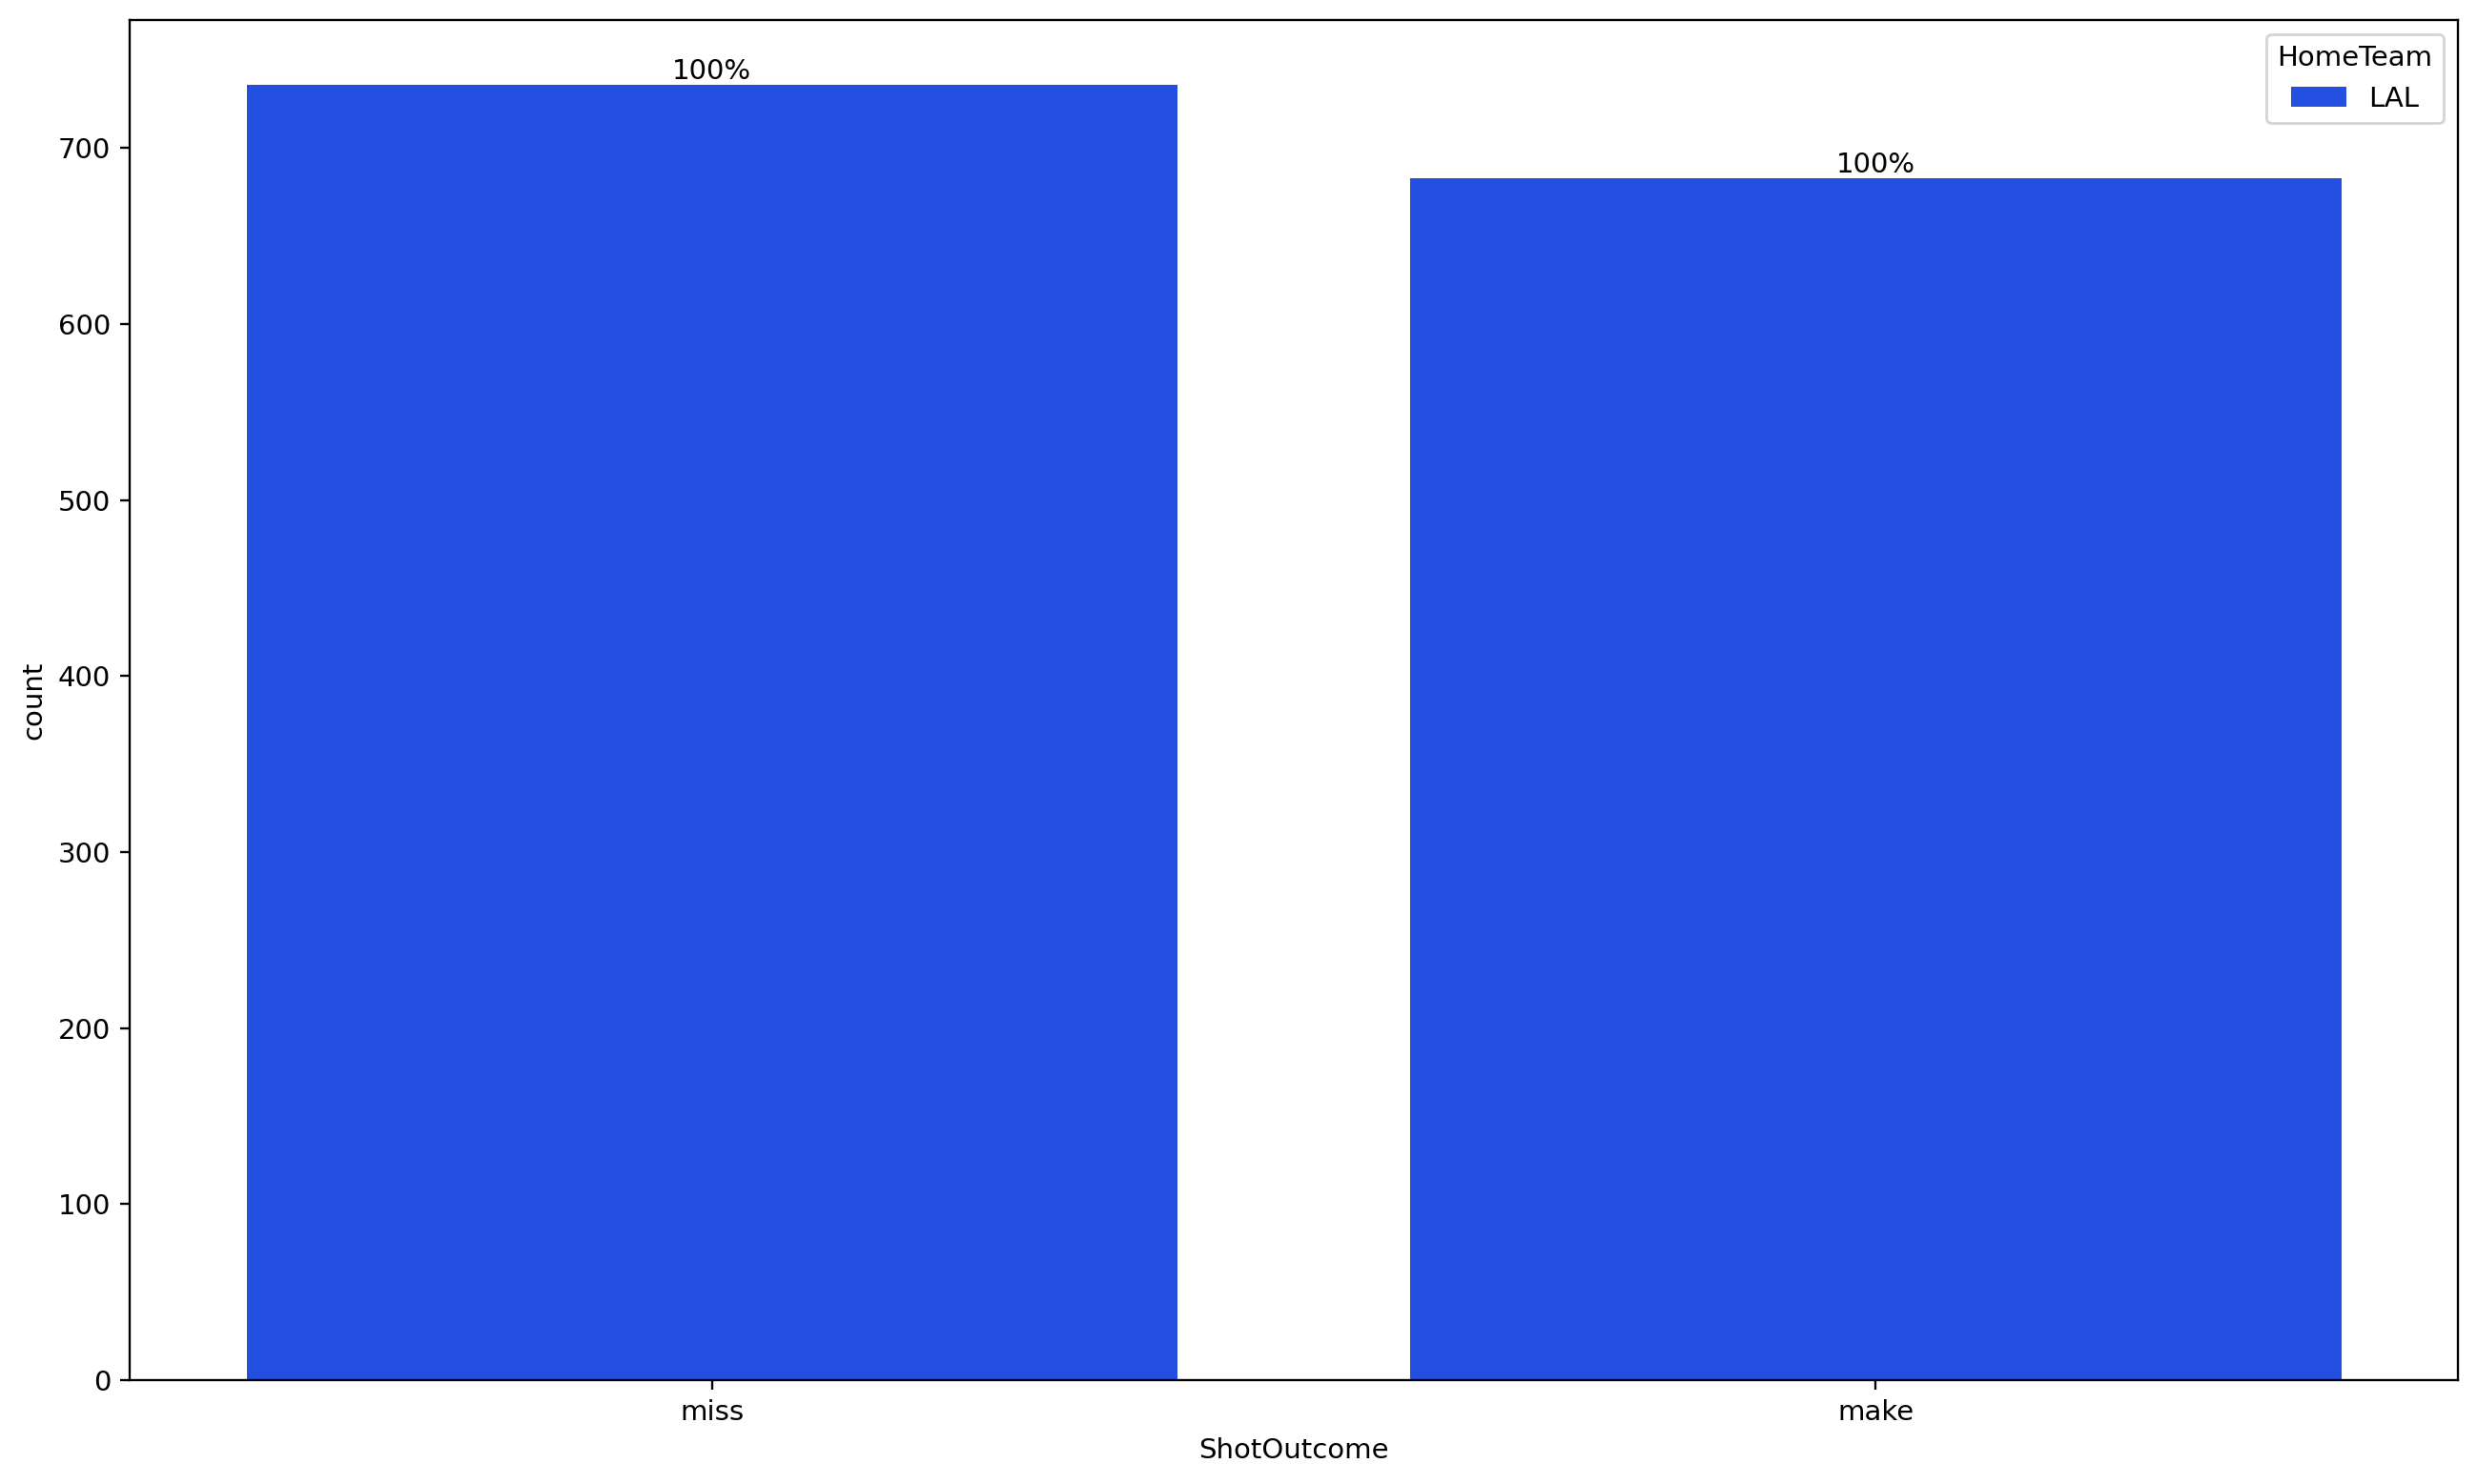

In [18]:
plt.figure(figsize=[15,9])
ax=sns.countplot(x='ShotOutcome',data=dfL_LAL,hue='HomeTeam',palette='bright')
barPerc(dfL_LAL,'ShotOutcome',ax)

## <span style="color:green">Cestas hechas y erradas de los equipos visitantes:

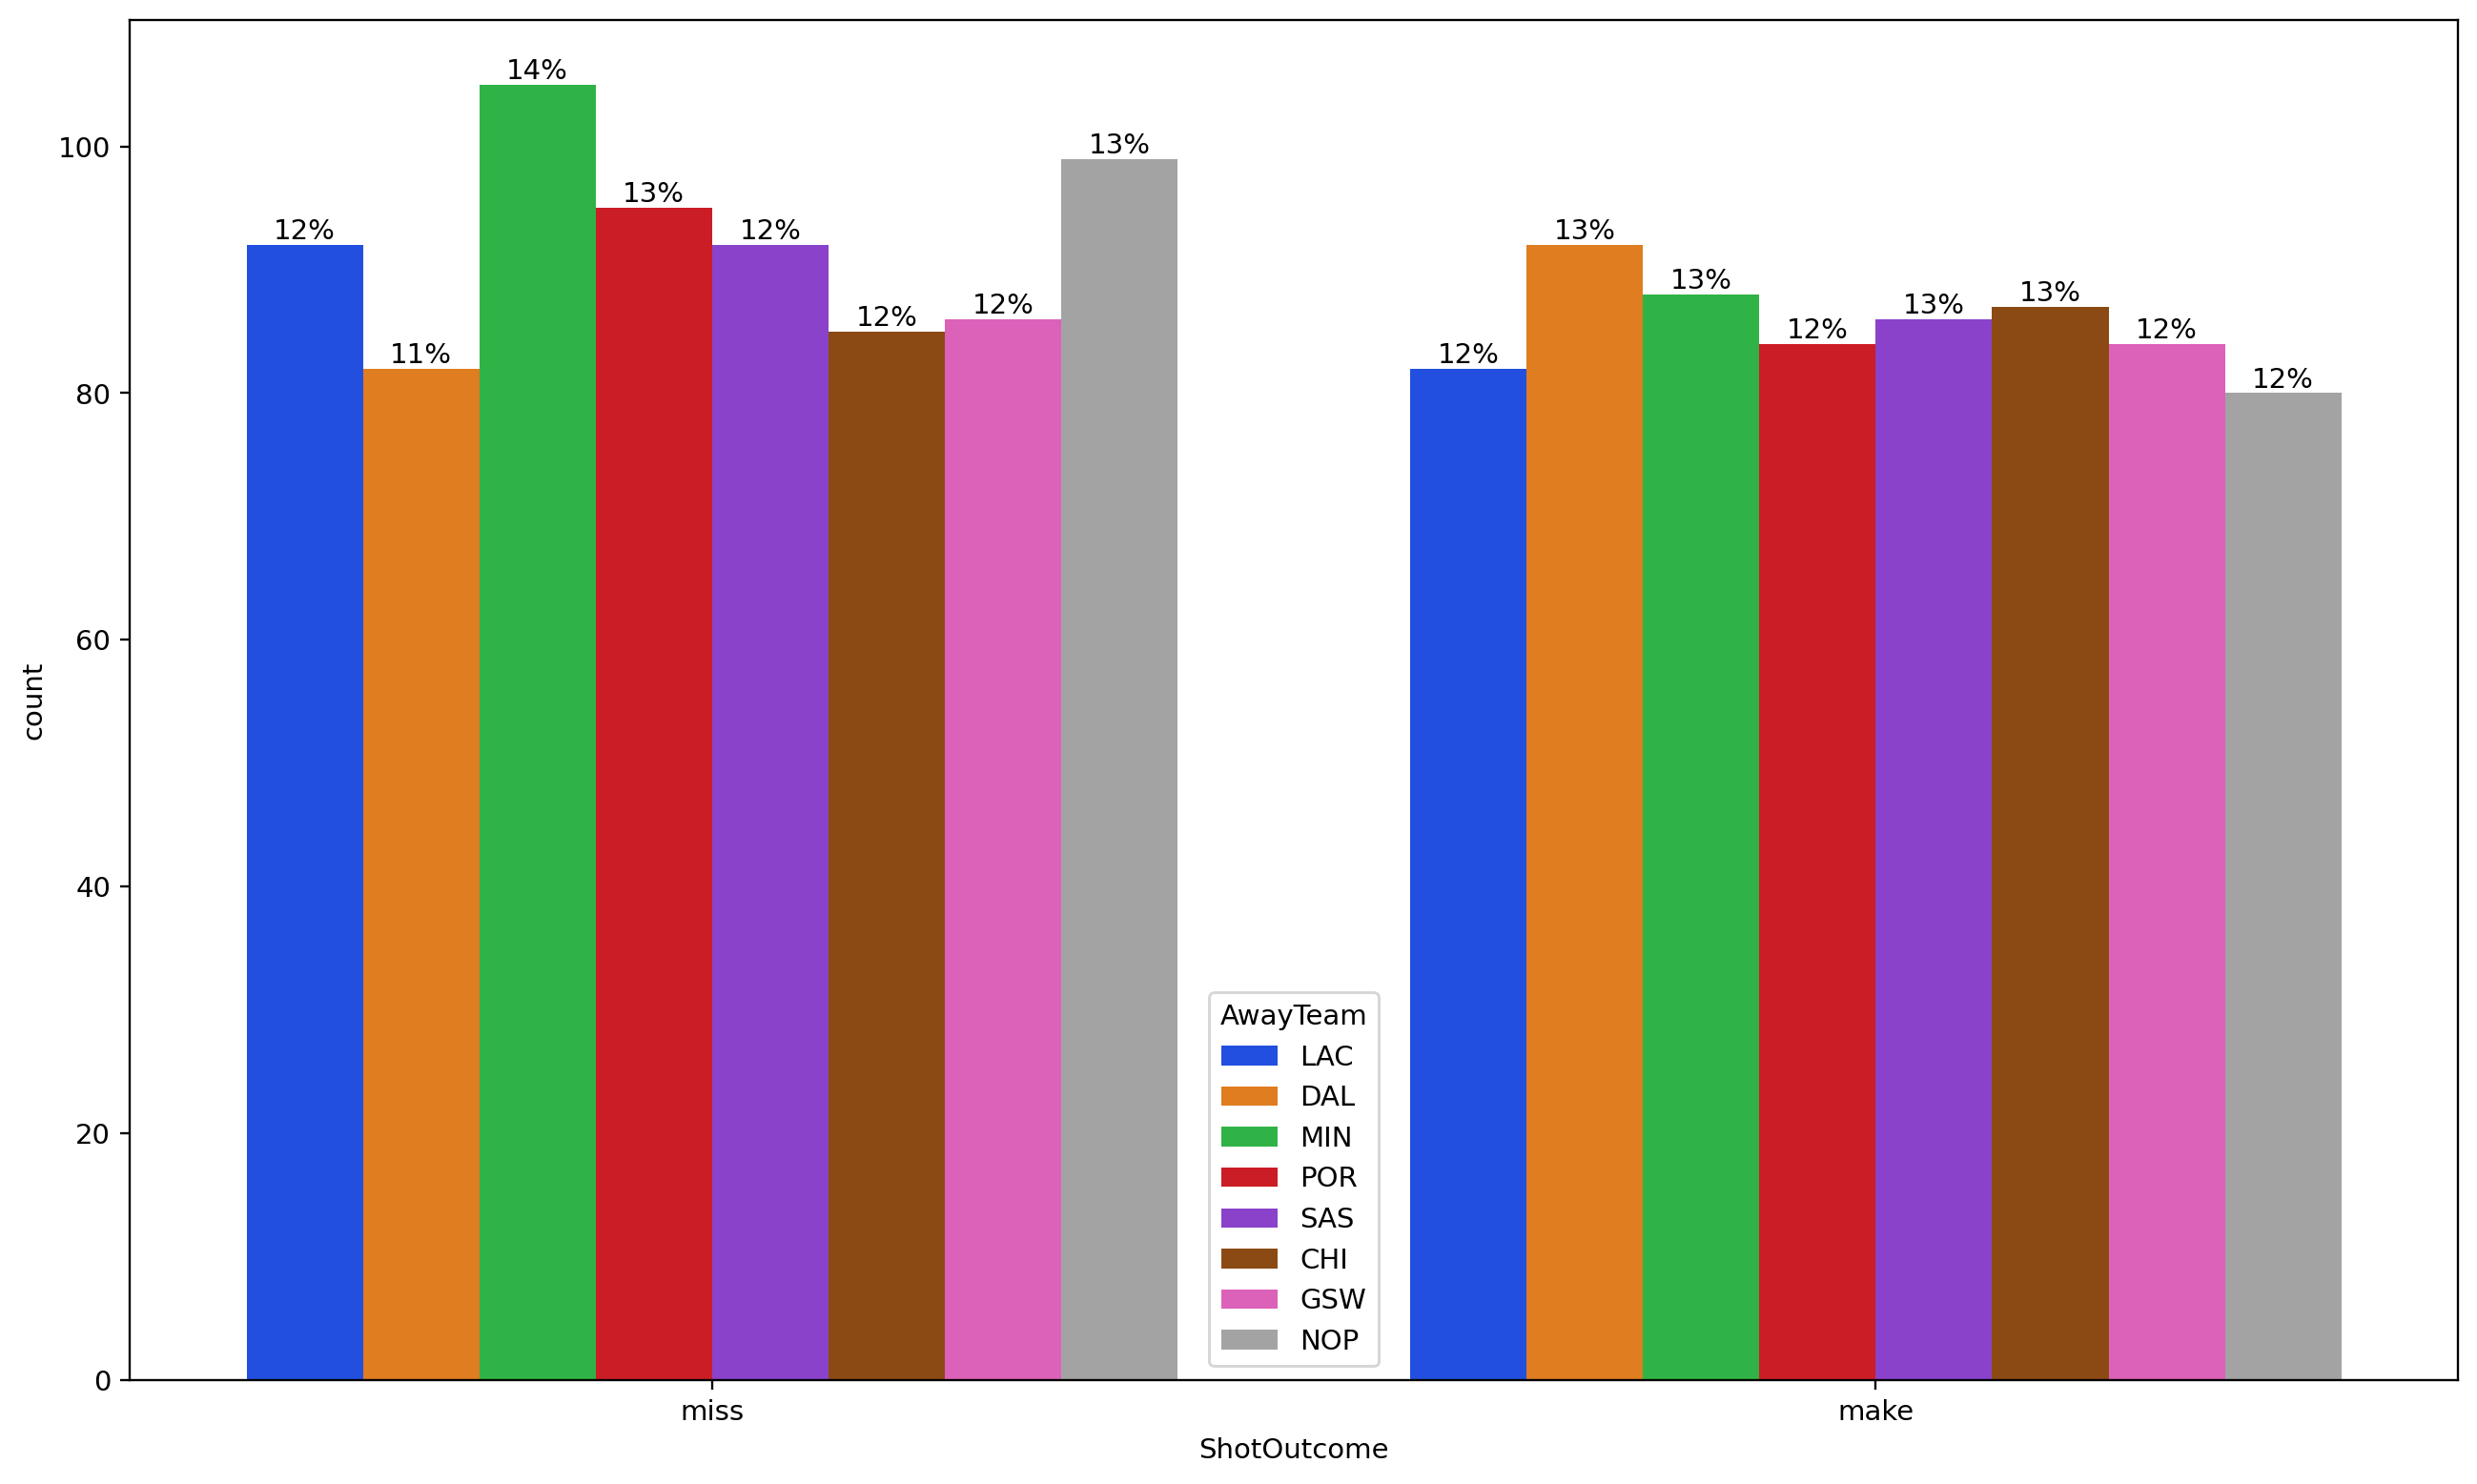

In [19]:
plt.figure(figsize=[15,9])
ax=sns.countplot(x='ShotOutcome',data=dfL_LAL,hue='AwayTeam',palette='bright')
barPerc(dfL_LAL,'ShotOutcome',ax)

# <span style="color:blue">Los Angeles Lakers (LAL) de visitante:

In [20]:
dfV_LAL=dfv_LAL

num_visitante=dfV_LAL['Date'].nunique()
P_acierto_V=dfV_LAL['ShotOutcome'].value_counts().min()/dfV_LAL['ShotOutcome'].value_counts().sum()

print(f'Hubieron {num_visitante} partidos donde LAL fue local los cuales tuvieron un porcentaje de acierto del {np.round(P_acierto_V*100,1)}% \n' 
      '(considerando cestas hechas y erradas por ambos equipos) ')

Hubieron 7 partidos donde LAL fue local los cuales tuvieron un porcentaje de acierto del 44.9% 
(considerando cestas hechas y erradas por ambos equipos) 


## <span style="color:green">Cestas hechas y erradas de los equipos locales:

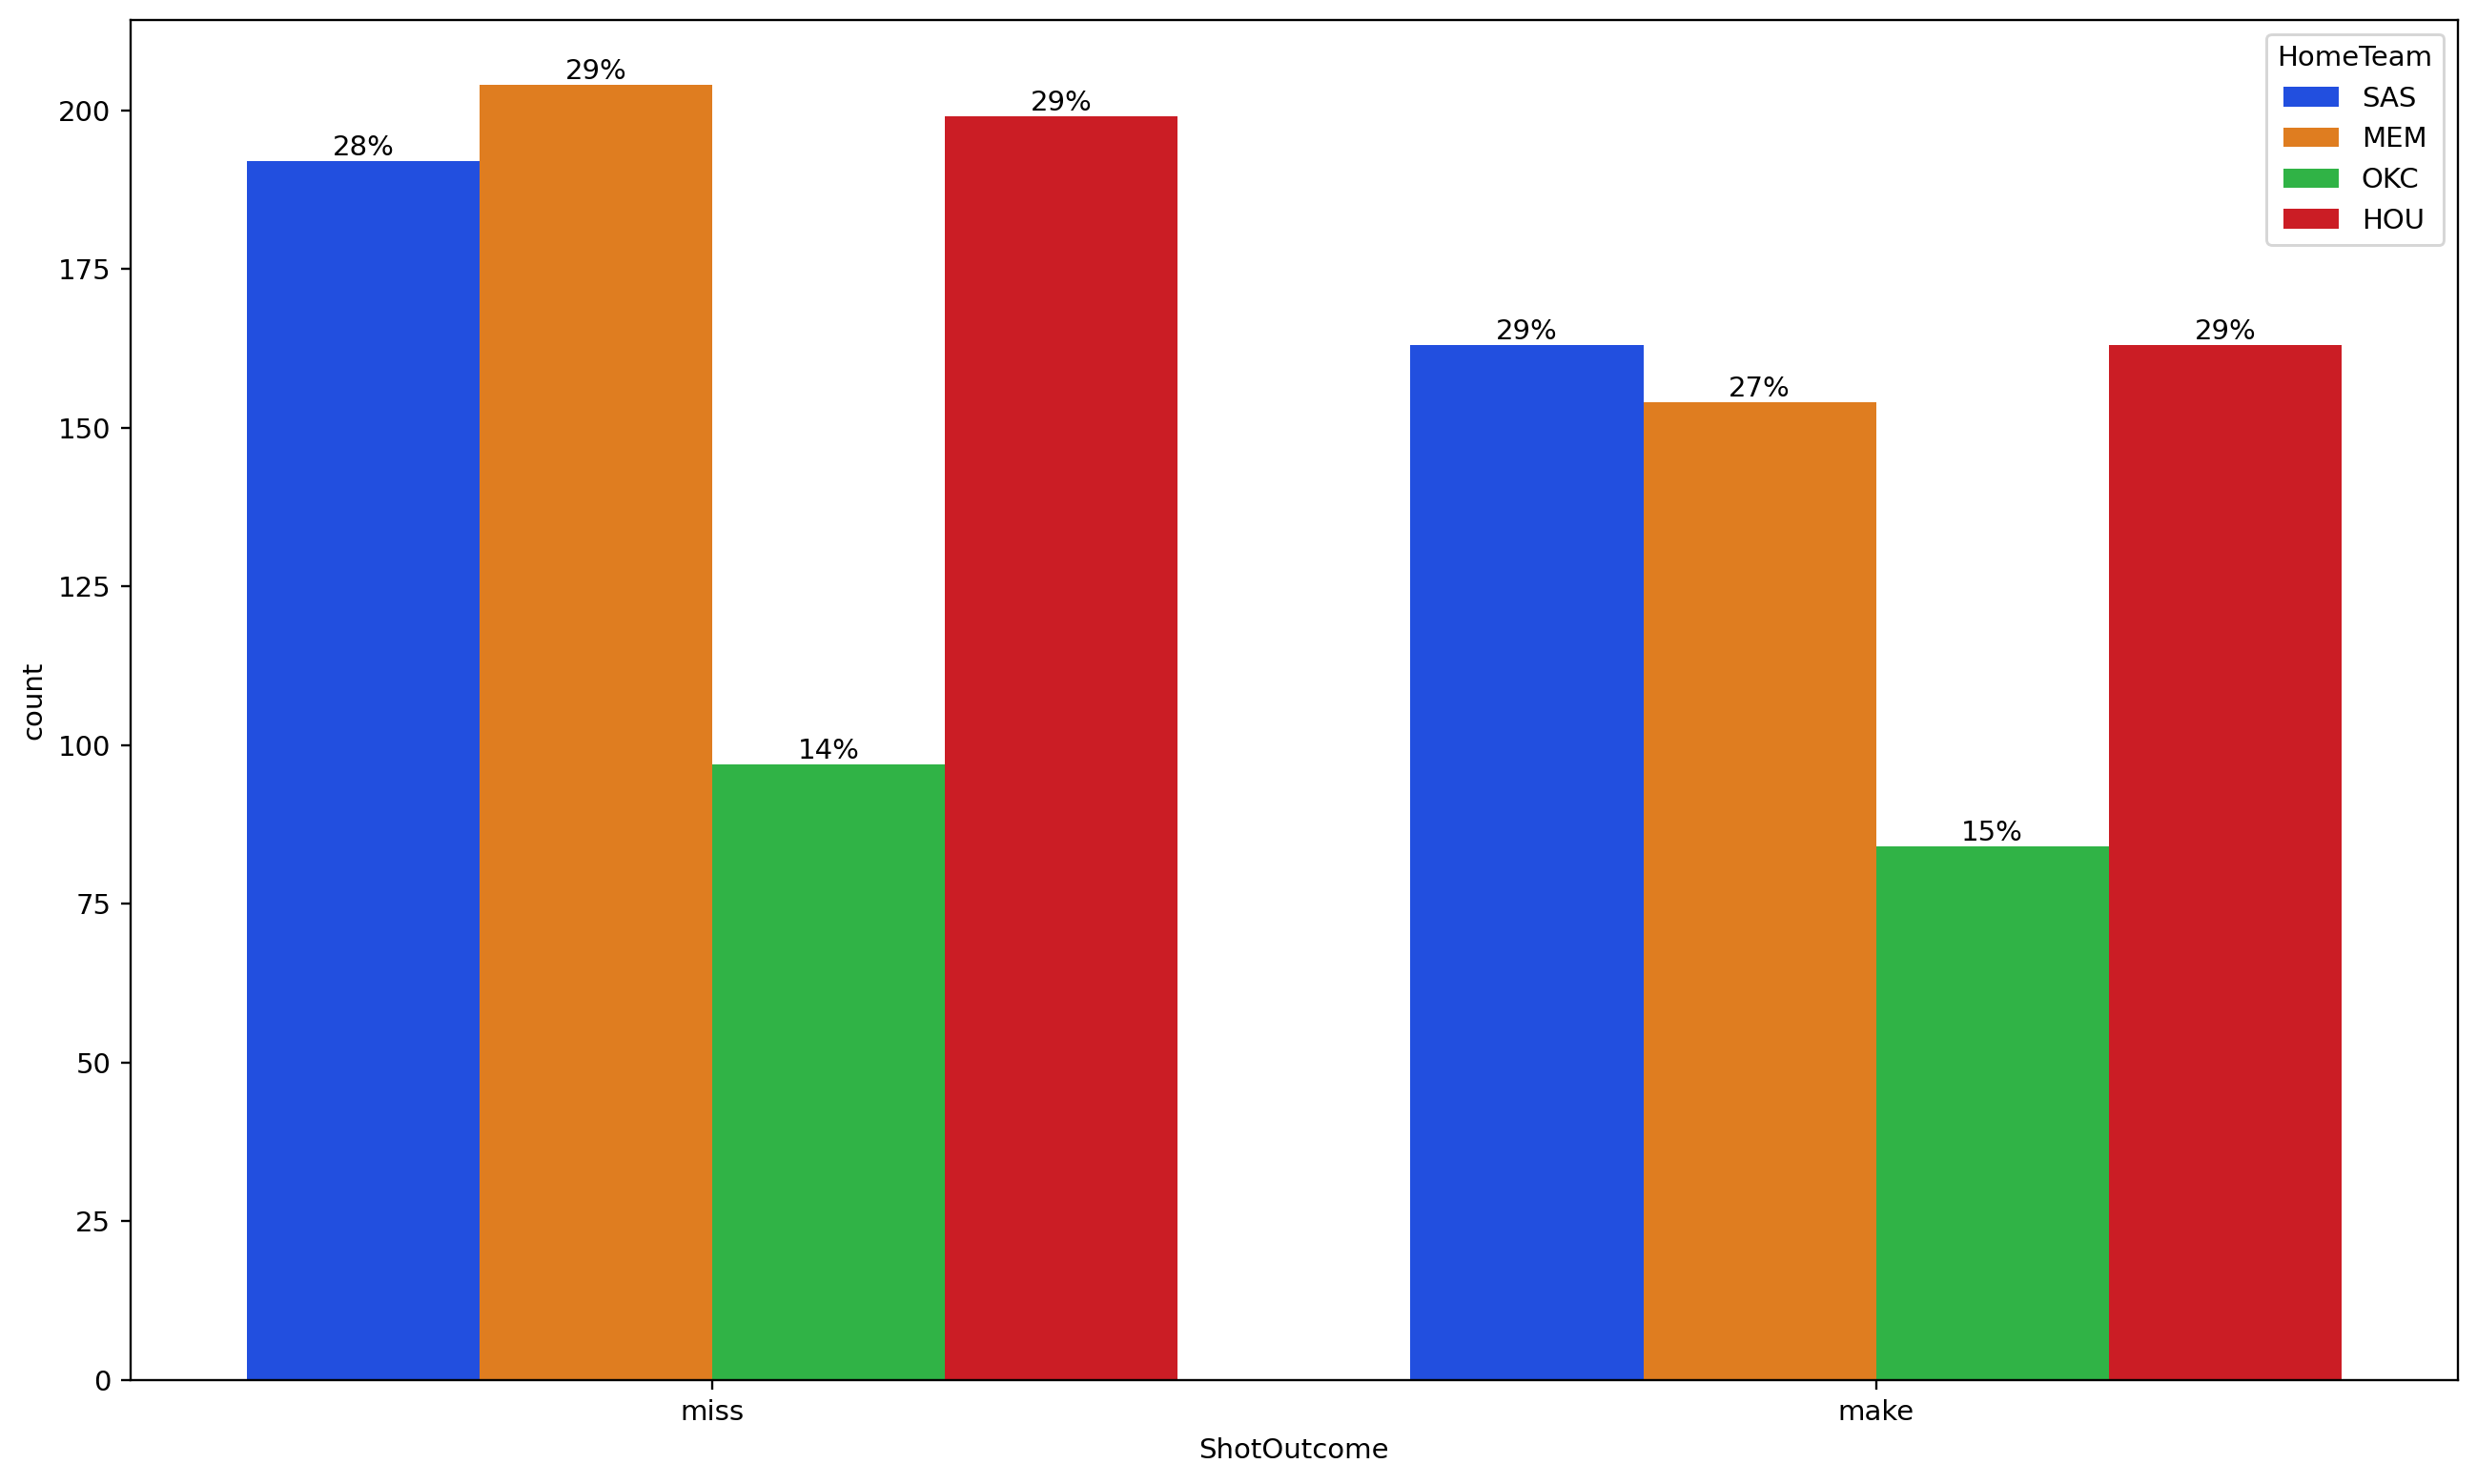

In [21]:
plt.figure(figsize=[15,9])
ax=sns.countplot(x='ShotOutcome',data=dfV_LAL,hue='HomeTeam',palette='bright')
barPerc(dfV_LAL,'ShotOutcome',ax)

## <span style="color:blue">Cestas hechas y erradas del equipo visitante:

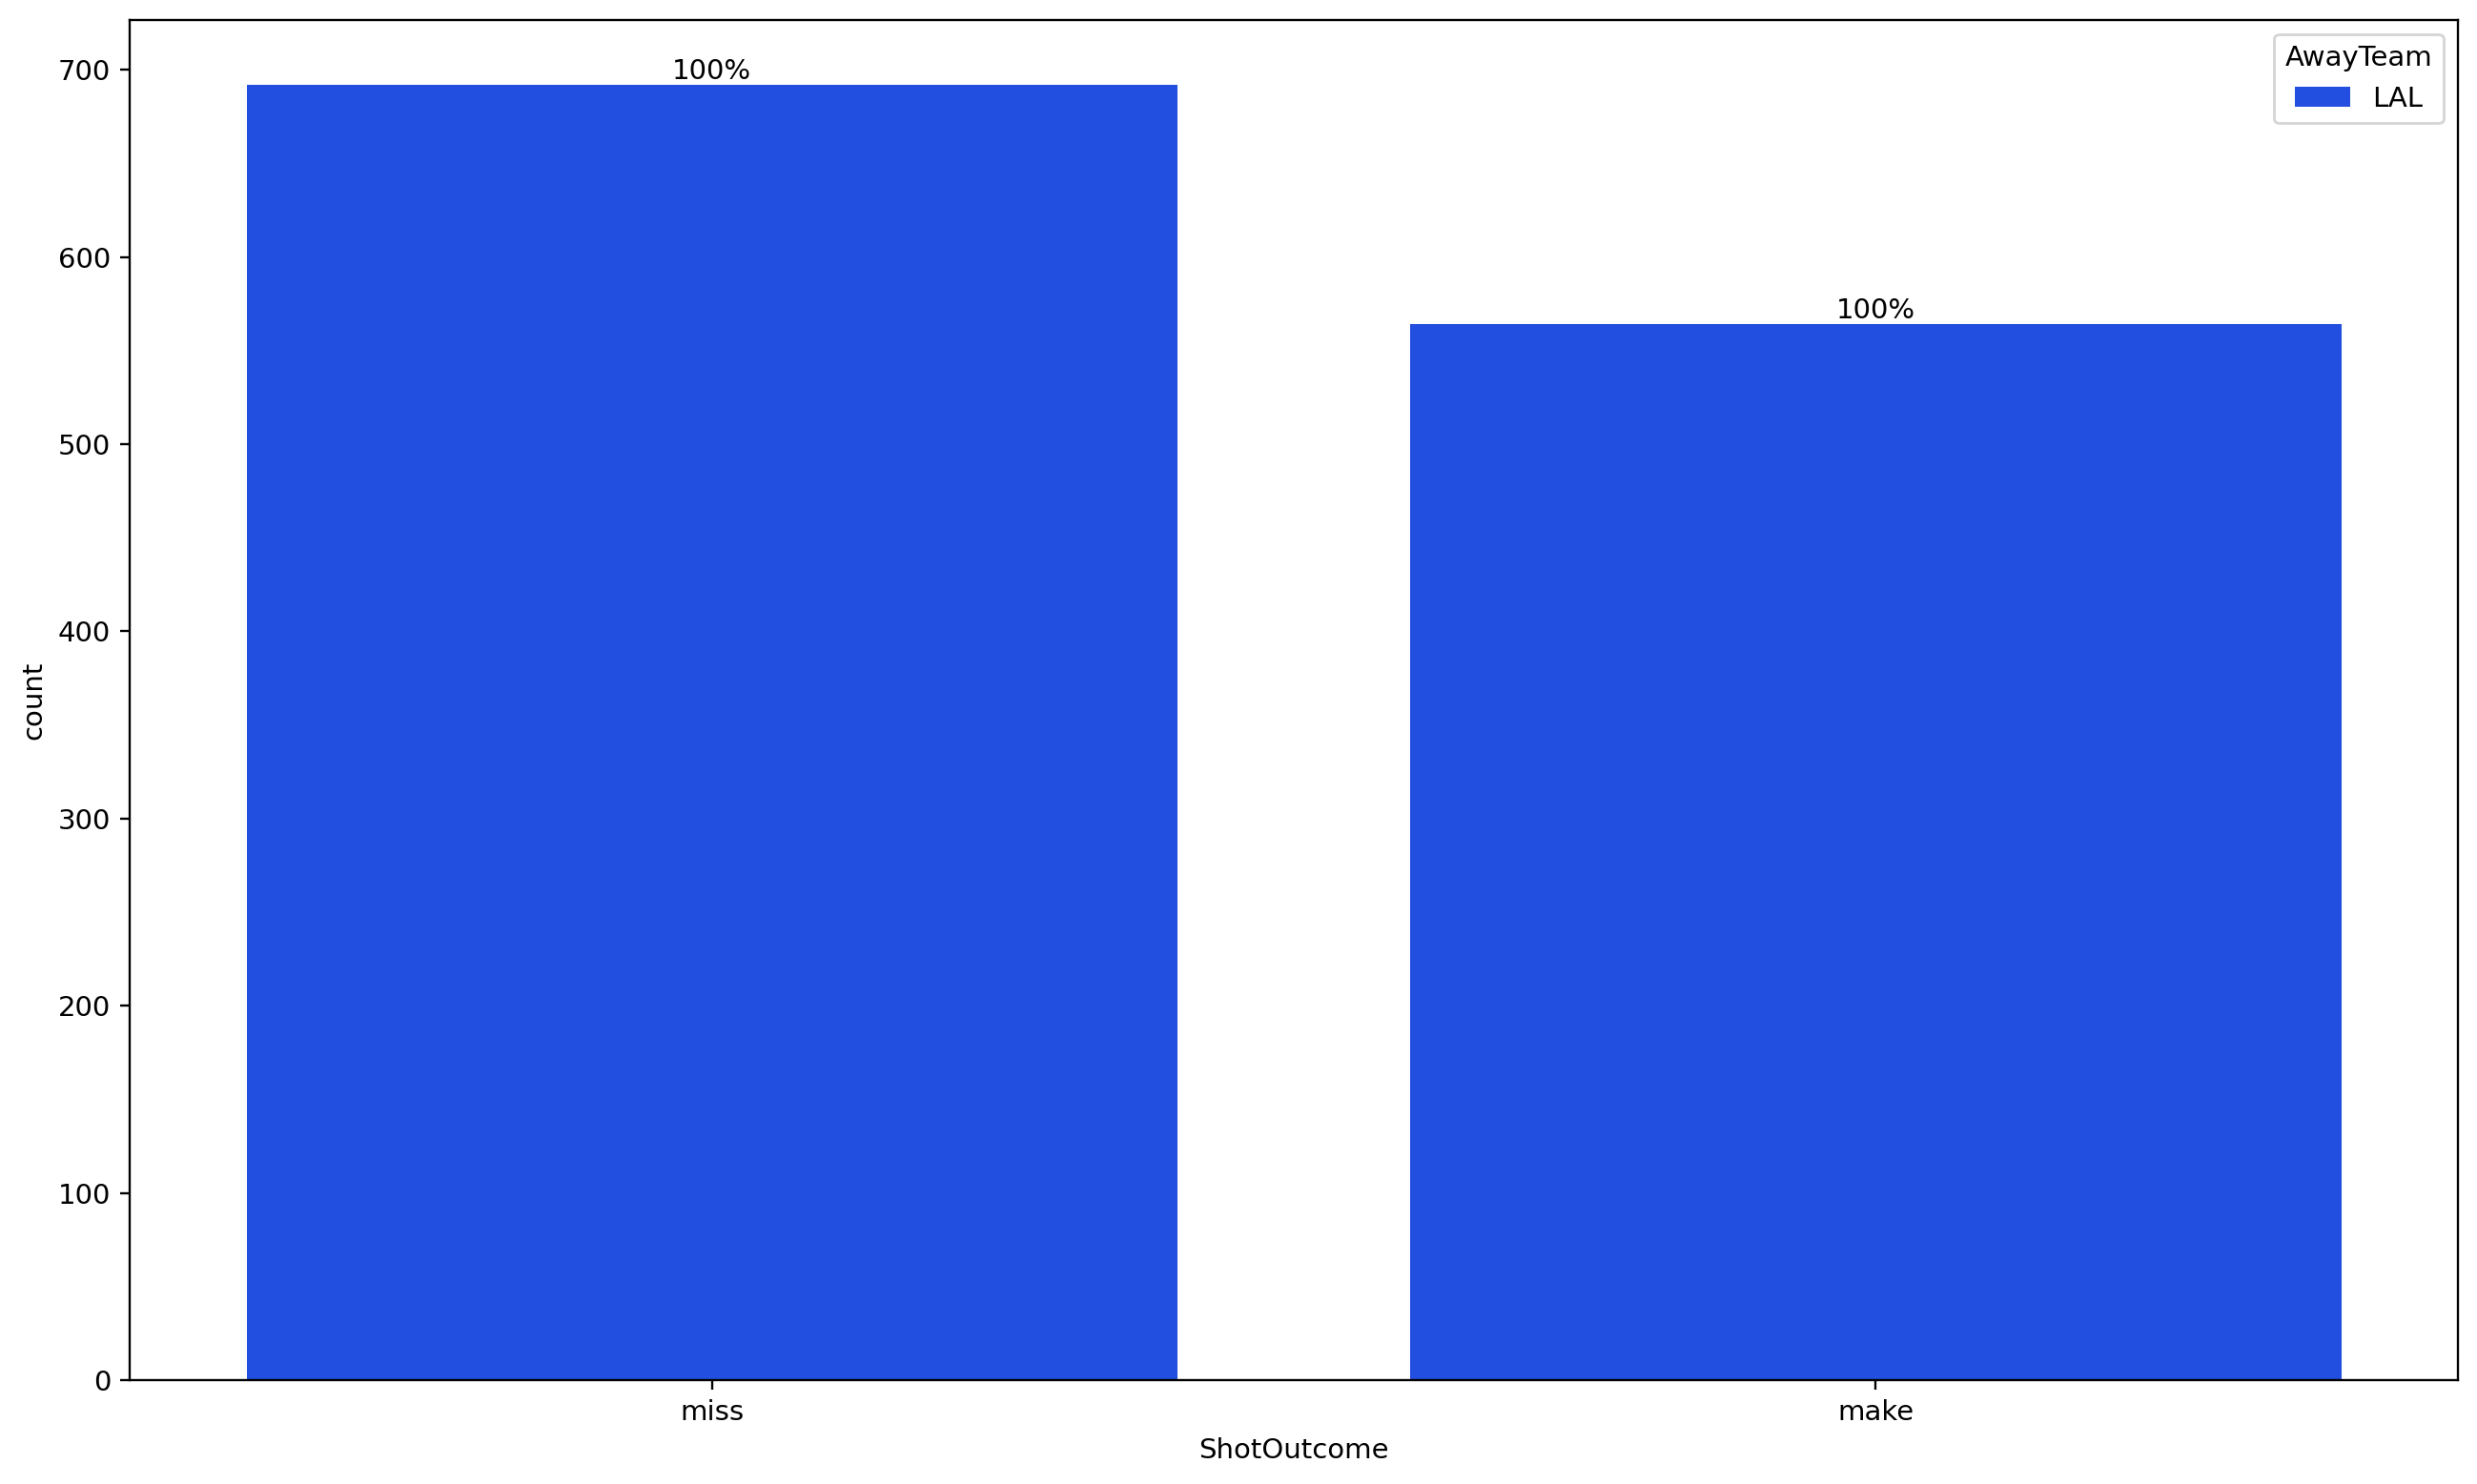

In [22]:
plt.figure(figsize=[15,9])
ax=sns.countplot(x='ShotOutcome',data=dfV_LAL,hue='AwayTeam',palette='bright')
barPerc(dfV_LAL,'ShotOutcome',ax)

## <span style="color:purple"> Normalización y organización del tiempo de manera continua

### Para reordenar el tiempo tal que arranque en 0 y no se reinicie la cuenta en cada cuarto se debe modificar la columna 'SecLeft' tal como se hace a continuación:
### ▲Se parte el dataframe de acuerdo al número de cuartos 
### ▲Recordando que cada cuarto contiene 720 segundos y en total el partido tiene 2880 segundos se realiza la conversión temporal y se normalize tal que el partido empieze en 0 y termine en 1, dicha conversión asegura también que el tiempo se ordene de manera continua durante todo el partido

In [23]:
df_game1=df_LAL #creando una copia 

In [24]:
df_game11Q=df_game1[df_game1['Quarter']==1] # Haciendo la conversión temporal para el primer cuarto de juego
df_game11Q['SecLeft']=(720-df_game11Q['SecLeft'])/2880

df_game12Q=df_game1[df_game1['Quarter']==2] # Haciendo la conversión temporal para el segundo cuarto de juego
df_game12Q['SecLeft']=(1440-df_game12Q['SecLeft'])/2880

df_game13Q=df_game1[df_game1['Quarter']==3] # Haciendo la conversión temporal para el tercer cuarto de juego
df_game13Q['SecLeft']=(2160-df_game13Q['SecLeft'])/2880

df_game14Q=df_game1[df_game1['Quarter']==4] # Haciendo la conversión temporal para el cuarto cuarto de juego
df_game14Q['SecLeft']=(2880-df_game14Q['SecLeft'])/2880

### Juntando las particiones y conversiones hechas:

In [25]:
df_game1Q=pd.concat([df_game11Q,df_game12Q,df_game13Q,df_game14Q])
df_game1Q=df_game1Q.reset_index()  #redefiniendo la cuenta del índice de cada fila
df_game1Q=df_game1Q.drop(columns=['index','level_0'])

## Renombrando la columna 'SecLeft' a 'Sec' (haciendo referencia a segundos transcurridos) y viendo los valores de segundos que hay:

In [26]:
df_game1Q=df_game1Q.rename(columns={'SecLeft':'Sec'})

In [27]:
df_game1Q['Sec'].nunique()

2353

## Seleccionando el final de los tres primeros cuartos con el fin de calcular la diferencia de puntos en cada uno de ellos:

In [28]:
df_ejemplo=df_game1Q #Creando una copia
df_dif1=df_ejemplo[df_ejemplo['AwayPlay']=='End of 1st quarter']
df_dif1=df_dif1.reset_index()  #redefiniendo la cuenta del índice de cada fila

df_dif2=df_ejemplo[df_ejemplo['AwayPlay']=='End of 2nd quarter']
df_dif2=df_dif2.reset_index()  #redefiniendo la cuenta del índice de cada fila

df_dif3=df_ejemplo[df_ejemplo['AwayPlay']=='End of 3rd quarter']
df_dif3=df_dif3.reset_index()  #redefiniendo la cuenta del índice de cada fila

## Creando un nuevo DataFrame de 60 filas (4 filas para cada partido)

In [29]:
df_dif=pd.concat([df_dif1,df_dif2,df_dif3,df_dif3])
df_dif=df_dif.reset_index()

# <span style="color:purple"> Determinación del arrastre

## Ingresando las tasas de apuestas de la casa BET365:

In [30]:
T_0=np.array([2.0,6.0,10.5,5.5,8.5,8.5,8.5,8.5,-7.5,-7.5,-10.0,-9.5,-10.5,-3.5,-5.5])         #Inicio del partido
T_1=np.array([-11.5,6.5,17.5,9.5,3.5,3.5,15.5,2.5,-10.5,-3.5,-2.5,-4.5,-14.5,-5.5,-19.5])     #Fin del 1er cuarto
T_2=np.array([1.5,12.5,21.5,1.5,-1.5,5.5,15.5,5.5,-11.5,-6.5,-8.5,-4.5,-15.5,-15.5,-50.0])    #Fin del 2do cuarto
T_3=np.array([-7.5,11.5,35.5,3.5,2.5,6.5,11.5,12.5,-10.5,-2.5,-6.5,-3.5,-22.5,-11.5,-50.0])   #Fin del 3er cuarto

## Ordenando las tasas de apuestas con su partido, tiempo y diferencia de puntos:

In [31]:
T=np.zeros(num_games*4)    #Tasa de apuesta
DIF=np.zeros(num_games*4)  #Diferencia de puntos
E=[None] * num_games*4     #Evento
S=np.zeros(num_games*4)    #Segundos
D=[None] * num_games*4     #Fecha
L=[None] * num_games*4     #Local
V=[None] * num_games*4     #Visitante

for i in range(0,num_games*4,4):
    j=float(i)/4
    
    S[i], E[i],T[i]=0,'Comienzo del partido',T_0[int(j)]
    S[i+1], E[i+1],T[i+1]=0.25,'Fin del 1er cuarto',T_1[int(j)]
    S[i+2], E[i+2],T[i+2]=0.5,'Fin del 2do cuarto',T_2[int(j)]
    S[i+3], E[i+3],T[i+3]=0.75,'Fin del 3er cuarto',T_3[int(j)]
    
    D[i]=df_dif1.loc[int(j),'Date']
    D[i+1],D[i+2],D[i+3]= ' ',' ',' '
    
    DIF[i+1]=int(df_dif1.loc[int(j),'HomeScore']-df_dif1.loc[int(j),'AwayScore'])
    DIF[i+2]=int(df_dif2.loc[int(j),'HomeScore']-df_dif2.loc[int(j),'AwayScore'])
    DIF[i+3]=int(df_dif3.loc[int(j),'HomeScore']-df_dif3.loc[int(j),'AwayScore'])
    
    L[i],V[i]=df_dif1.loc[int(j),'HomeTeam'],df_dif1.loc[int(j),'AwayTeam']
    L[i+1], L[i+2], L[i+3]=' ',' ',' '
    V[i+1], V[i+2], V[i+3]=' ',' ',' '   

## Calculando el parámetro de arrastre

In [32]:
u=np.round(-0.885*T,3) #Implementando el parámetro de arrastre

## Integrando las columnas anteriores al DataFrame creado recientemente

In [33]:
DATE=pd.Series(D)
df_dif['Local']=L
df_dif['Visitante']=V
df_dif['DifScore']=DIF.tolist()
df_dif['Evento']=E
df_dif['Tiempo']=S.tolist()
df_dif['TasaApuesta']=T.tolist()
df_dif['Arrastre (u)']=u.tolist()

## Tomando las columnas de interés, viendo el DataFrame y la información de este: 

In [34]:
DF=df_dif[['Local','Visitante','DifScore','Evento','Tiempo','TasaApuesta','Arrastre (u)']]
DF=DF.set_index(DATE)
DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, December 22 2020 to  
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Local         60 non-null     object 
 1   Visitante     60 non-null     object 
 2   DifScore      60 non-null     float64
 3   Evento        60 non-null     object 
 4   Tiempo        60 non-null     float64
 5   TasaApuesta   60 non-null     float64
 6   Arrastre (u)  60 non-null     float64
dtypes: float64(4), object(3)
memory usage: 3.8+ KB


In [35]:
DF

,Local,Visitante,DifScore,Evento,Tiempo,TasaApuesta,Arrastre (u)
December 22 2020,LAL,LAC,0.0,Comienzo del partido,0.00,2.0,-1.770
,,,-20.0,Fin del 1er cuarto,0.25,-11.5,10.178
,,,-2.0,Fin del 2do cuarto,0.50,1.5,-1.328
,,,-11.0,Fin del 3er cuarto,0.75,-7.5,6.638
December 25 2020,LAL,DAL,0.0,Comienzo del partido,0.00,6.0,-5.310
,,,3.0,Fin del 1er cuarto,0.25,6.5,-5.752
,,,12.0,Fin del 2do cuarto,0.50,12.5,-11.062
,,,14.0,Fin del 3er cuarto,0.75,11.5,-10.178
December 27 2020,LAL,MIN,0.0,Comienzo del partido,0.00,10.5,-9.292
,,,17.0,Fin del 1er cuarto,0.25,17.5,-15.488


# <span style="color:purple"> Definición de las funciones a usar

## Creando inicialmente dichas funciones como matrices vacías:

In [36]:
a=np.zeros((4,num_games))        #coeficientes
f=np.zeros((3,num_games))        #f
phi=np.zeros((3,num_games))      #phi

# <span style="color:purple">Método Newton Rhapson para determinar desviación estandar (sigma)

In [37]:
error,l,MaxIter=1,1,100 #parámetros a usar
sigma=np.pi #punto medio del intervalo a usar
y=np.array([1,1,1,0,0,1,0,1,0,0,0,0,0,0,0])
k =np.linspace(-150,100,2000)


while error<7 and l<MaxIter:
    #Calculando el coeficiente a
    for j in range(num_games):   #índice para los partidos
        for i in range(4):       #índice para los cuartos de juego
            a[i][j]=(DIF[4*j+i]+(1-(i/4))*u[4*j+i])/(np.sqrt(
                (1-(i/4))*sigma**2))
            
    #calculando f
    for j in range(num_games):   #índice para los partidos
        for i in range(1,4):     #índice para los cuartos de juego
            t=float(i)/4         #tiempo 
            f[i-1][j]=(1/((sigma)*np.sqrt(
                2*np.pi*t)))*np.exp(-((a[i][j]-t*u[4*j+i])**2)/(2*t*sigma**2))
   
    #calculando la función de distribución acumulada (phi)
    for j in range(num_games):
        for i in range(1,4):
            def prueba(k):
                return np.exp(-((k-u[4*j+i])**2)/(2*sigma**2))
            qt1, err = quad(prueba, -150, a[i][j])
            phi[i-1][j]=qt1*(1/((sigma)*np.sqrt(2*np.pi)))
    
    def grad(sigma): #función a la cual se le busca hallar la raíz
        grad=0
        for j in range(num_games-4): #seleccionando partidos de entrenamiento
            for i in range(1,4):
                grad1=(1/sigma**2)*(a[i][j]*f[i-1][j])*(
                    phi[i-1][j]-y[j])/(phi[i-1][j]*(1-phi[i-1][j]))
                grad=grad+grad1   
        return grad
    
    #Derivada numérica de la función grad(x)
    def df(x):
        h=10**(-8) 
        return (grad(x+h)-grad(x))/h
    
    x1=sigma-grad(sigma)/df(sigma)
    error=np.abs(x1-sigma)
    sigma=x1
    l=l+1
print('Iteración',l-1,f'se obtuvo: sigma={np.round(sigma,3)}')

Iteración 5 se obtuvo: sigma=23.856


# <span style="color:purple"> Aplicación de los parámetros obtenidos

## Usando la desviación estandar obtenida para hallar  $\Phi$ en los partidos de prueba:

In [38]:
phi_test=np.zeros((3,4)) #4 partidos de prueba

In [39]:
for j in range(11,num_games):
    for i in range(1,4):
        def prueba(k):
            return np.exp(-((k-u[4*j+i])**2)/(2*sigma**2))
        qt1, err = quad(prueba, -150, a[i][j])
        l=int(float(j)-11)
        phi_test[i-1][l]=qt1*(1/((sigma)*np.sqrt(2*np.pi)))

## Probabilidad de que gane el local para los partidos de prueba:

In [40]:
phi_test

array([[0.44329934, 0.29598464, 0.41874082, 0.22725172],
       [0.4425194 , 0.27619442, 0.26753825, 0.0315771 ],
       [0.45204107, 0.17764305, 0.31499256, 0.02658231]])

## Probabilidad de que gane el visitante para los partidos de prueba:

In [41]:
1-phi_test

array([[0.55670066, 0.70401536, 0.58125918, 0.77274828],
       [0.5574806 , 0.72380558, 0.73246175, 0.9684229 ],
       [0.54795893, 0.82235695, 0.68500744, 0.97341769]])

## Calculando los coeficientes de Brier

In [42]:
brier=np.zeros((3,4)) #matriz vacia de coeficientes de Brier

In [43]:
for i in range(3):
    for j in range(4):
        brier[i][j]=(1/3)*np.abs(phi_test[i][j])**2

In [44]:
brier 

array([[0.06550477, 0.0292023 , 0.05844796, 0.01721445],
       [0.06527447, 0.02542779, 0.0238589 , 0.00033237],
       [0.06811371, 0.01051902, 0.03307344, 0.00023554]])

# <span style="color:purple"> Probando para un partido extra (Brooklyn Nets vs Washington Wizards)

## Usando la desviación estandar obtenida para hallar  $\Phi$ en el partido extra:

In [45]:
T_b=np.array([7.5,5.5,6.5,3.5])  #Tasas de apuestas
u_b=np.round(-0.885*T_b,3)       #Implementando el parámetro de arrastre

DIF_b=np.array([0,-1,3,-1])      #Diferencia de puntos

In [46]:
a_b=np.zeros((4,1))         #coeficientes
phi_b=np.zeros((3,1))       #phi
phi_test_b=np.zeros((3,1))  #4 partidos de prueba

In [47]:
for j in range(1):
        for i in range(4):
            a_b[i][j]=(DIF_b[4*j+i]+(1-(i/4))*u_b[4*j+i])/(np.sqrt((1-(i/4))*sigma**2))

In [48]:
for j in range(1):
    for i in range(1,4):
        def prueba(k):
            return np.exp(-((k-u_b[4*j+i])**2)/(2*sigma**2))
        qt1, err = quad(prueba, -150, a_b[i][j])
        l=int(j)
        phi_test_b[i-1][l]=qt1*(1/((sigma)*np.sqrt(2*np.pi)))

## Probabilidad de que gane el local para el partido extra:

In [49]:
phi_test_b #probabilidades para el local partido extra

array([[0.57715374],
       [0.59538393],
       [0.54919356]])

## Probabilidad de que gane el local para el partido extra:

In [50]:
1-phi_test_b

array([[0.42284626],
       [0.40461607],
       [0.45080644]])

## Calculando los coeficientes de Brier

In [51]:
brier_b=np.zeros((3,1)) #matriz vacia de puntajes de Brier

In [52]:
for i in range(3):
    for j in range(1):
        brier_b[i][j]=(1/3)*np.abs(phi_test_b[i][j])**2

In [53]:
brier_b  #puntajes de brier

array([[0.11103548],
       [0.11816068],
       [0.10053786]])